In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df_ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
df_hour = pd.read_csv('ads_hour.csv', index_col=['Date'], parse_dates=['Date'])
df_cur = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

In [3]:
df_ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [4]:
df_hour.head()

,ads
Date,
2017-08-03 00:00:00,49136
2017-08-03 01:00:00,46450
2017-08-03 02:00:00,46355
2017-08-03 03:00:00,43748
2017-08-03 04:00:00,42281


In [5]:
df_cur.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


In [6]:
print(df_ads.shape)
print(df_hour.shape)
print(df_cur.shape)

(216, 1)
(2085, 1)
(300, 1)


<center><b><u>Moving Window Averaging</u></b></center>

$$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}\tag{1}$$

In [7]:
def plotMovingAverage(series, win, scale=2.0):
    roll_mean = series.rolling(window=win).mean()
    plt.figure(figsize=(12, 8))
    plt.plot(roll_mean, 'g', label='rolling mean {}'.format(scale))
    
    mea = mean_absolute_error(series[win:], roll_mean[win:])
    deviation = np.std(series[win:] - roll_mean[win:])
    lower_bound = roll_mean - (mea + scale * deviation)
    upper_bound = roll_mean + (mea + scale * deviation)
    plt.plot(lower_bound, 'r--', label='upper/lower bound')
    plt.plot(upper_bound, 'r--')
    
    anomaly = pd.DataFrame(index=series.index, columns=series.columns)
    anomaly[series<lower_bound] = series[series<lower_bound]
    anomaly[series>upper_bound] = series[series>upper_bound]
    plt.plot(anomaly, 'ro', label='Anomaly')
    
    plt.plot(series, 'b', label='Real Data', alpha=0.3)
    plt.title('Moving Average Plot')
    plt.grid(True)
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.show()

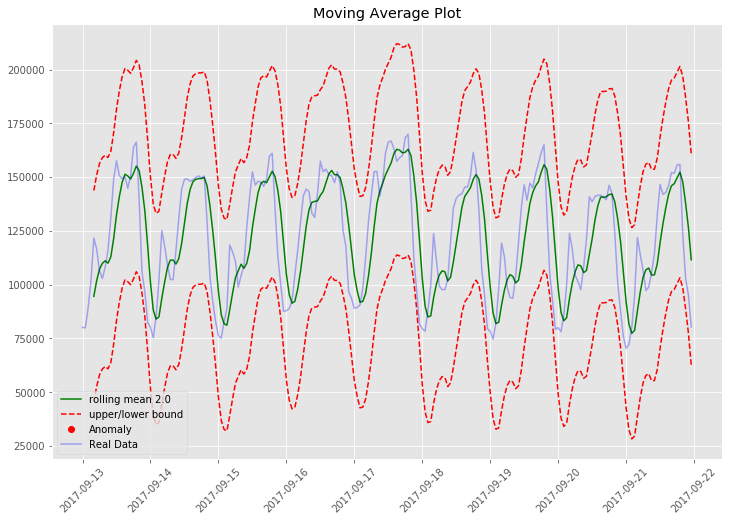

In [8]:
plotMovingAverage(df_ads, win=5)

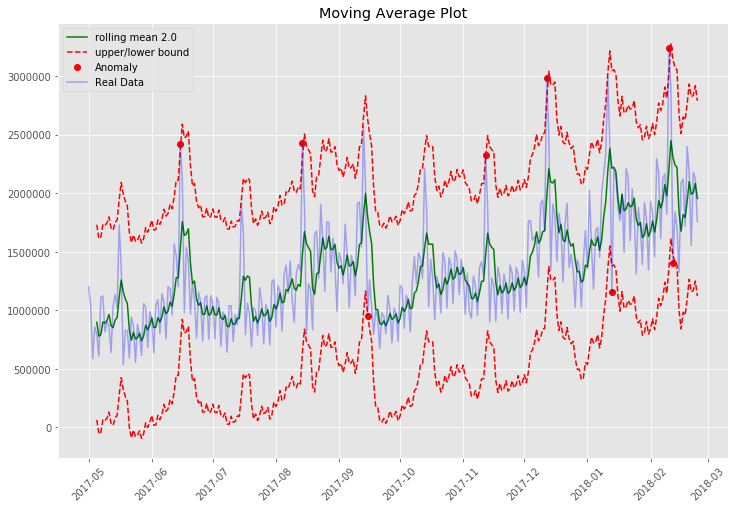

In [9]:
plotMovingAverage(df_cur, win=5)

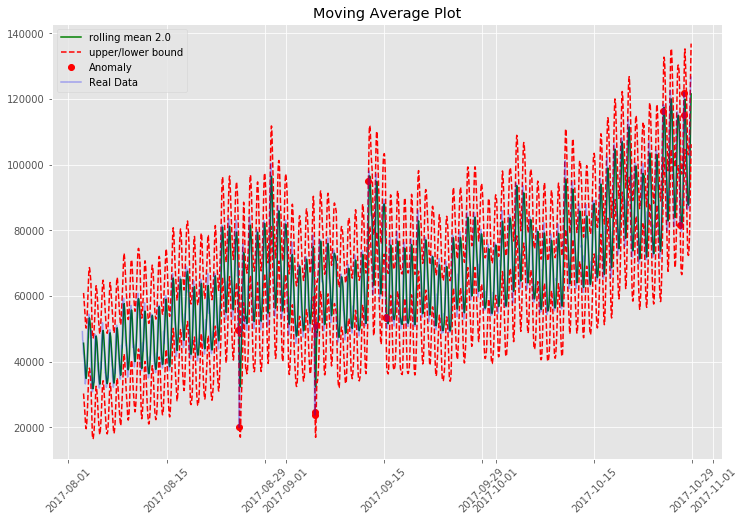

In [10]:
plotMovingAverage(df_hour, win=5)

<center><b><u>Exponential Smoothing</u></b></center>

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}\tag{1}$$

In [11]:
def exponantialSmooth(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append((alpha * series[n]) + ((1 - alpha) * result[n-1]))
    return result

In [12]:
def plotExpoSmooth(series, alphas):
    with plt.style.context('ggplot'):
        plt.figure(figsize=(12, 8))
        for alpha in alphas:
            plt.plot(exponantialSmooth(series, alpha), label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label='Actual', alpha=0.4)
        plt.title('Exponantial Average')
        plt.axis('tight')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

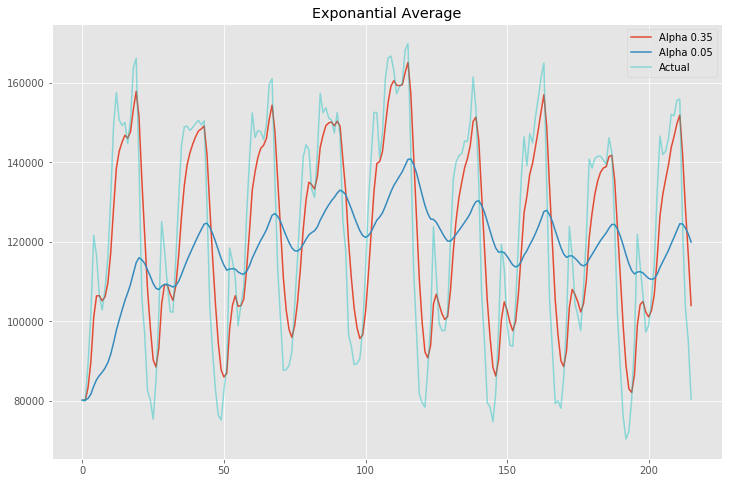

In [13]:
plotExpoSmooth(df_ads.Ads, [0.35, 0.05])

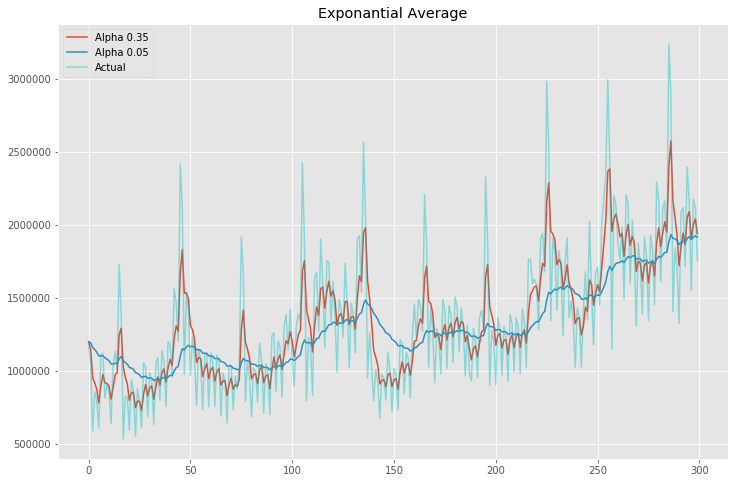

In [14]:
plotExpoSmooth(df_cur.GEMS_GEMS_SPENT, [0.35, 0.05])

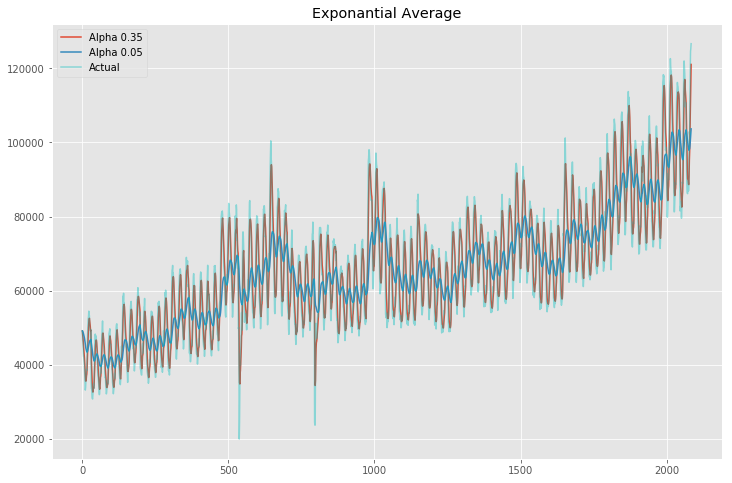

In [15]:
plotExpoSmooth(df_hour.ads, [0.35, 0.05])

<center><b><u>Double Exponential Smoothing</u></b></center>

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})\tag{1}$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}\tag{2}$$

$$\hat{y}_{x+1} = \ell_x + b_x\tag{3}$$

In [16]:
def doubleExpoSmooth(series, alpha, beta):
    res = [series[0]]
    for n in range(1, len(series) + 1):
        if n==1:
            level = res[0]
            trend = series[1] - series[0]
        if n>=len(series):
            value = res[-1]
        else:
            value = series[n]
            
            last_level = level
            level = alpha * value + (1 - alpha) * (level + trend)
            trend = beta * (level - last_level) + (1 - beta) * (trend)
        res.append(level + trend)
    return res

In [17]:
def plotDoubleExpoSmooth(series, alphas, betas):
    with plt.style.context('ggplot'):
        plt.figure(figsize=(12, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(doubleExpoSmooth(series, alpha, beta), label='Alpha {} beta {}'.format(alpha, beta))
        plt.plot(series.values, 'c', label='Actual', alpha=0.5)
        plt.title('Double Exponential Smooth')
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc='best')

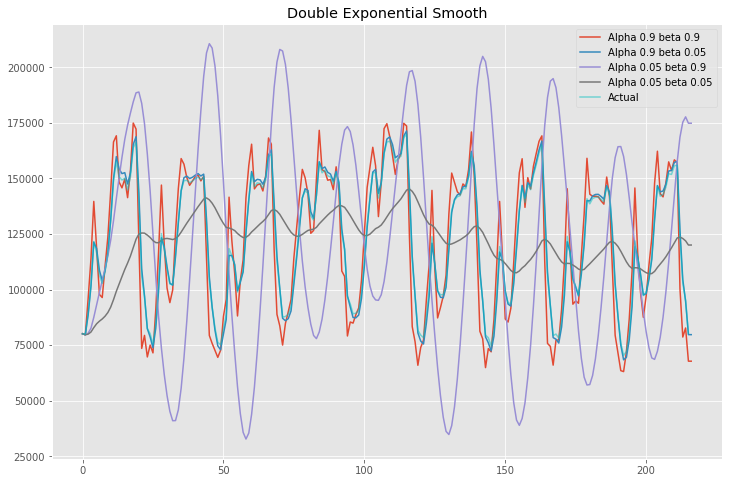

In [18]:
plotDoubleExpoSmooth(df_ads.Ads, [0.9, 0.05], [0.9, 0.05])

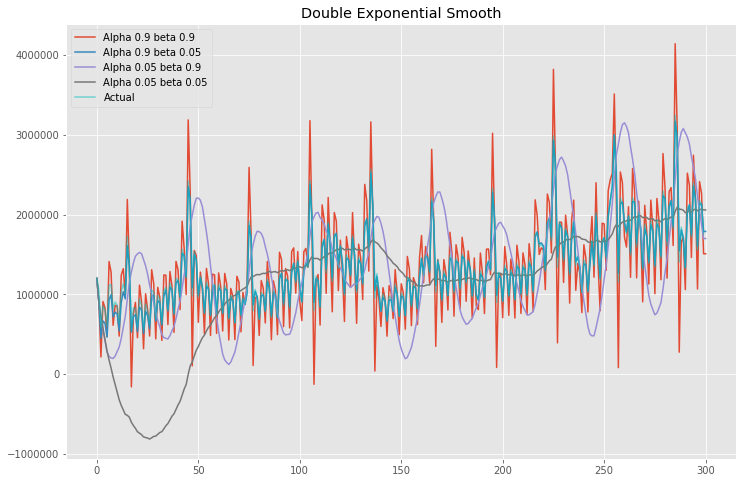

In [19]:
plotDoubleExpoSmooth(df_cur.GEMS_GEMS_SPENT, [0.9, 0.05], [0.9, 0.05])

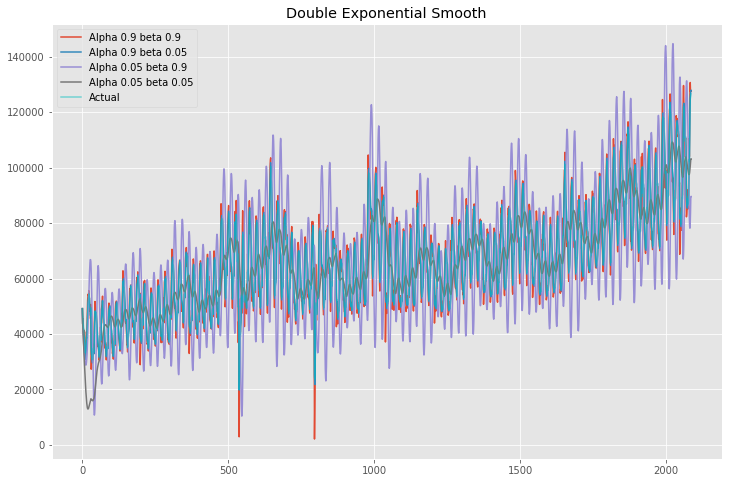

In [20]:
plotDoubleExpoSmooth(df_hour.ads, [0.9, 0.05], [0.9, 0.05])

<center><b><u>Triple Exponential Smoothing (HoltWinters)</u></b></center>

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})\tag{1}$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}\tag{2}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}\tag{3}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}\tag{4}$$

In this Class, Burtlag method was also included to calculate the confidence interval.

<center><b><u>Burtlag Method</u></b></center>

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}\tag{1}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}\tag{2}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}\tag{3}$$

In [21]:
class HoltWinters:
    
    def __init__(self, series, s_len, alpha, beta, gamma, n_pred, scale_factor=1.96):
        self.series = series
        self.s_len = s_len
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_pred = n_pred
        self.scale_factor = scale_factor   
        
    def initial_trend(self):
        summ = 0.0
        for i in range(self.s_len):
            summ += float(self.series[i+self.s_len] - self.series[i]) / self.s_len
        return summ / self.s_len

    def initial_seasonal_component(self):
        season = {}
        season_average = []
        n_season = int(len(self.series)/self.s_len)
        for j in range(n_season):
            season_average.append(sum(self.series[self.s_len*j:self.s_len*j+self.s_len])/float(self.s_len))
        for i in range(self.s_len):
            sum_vals_over_avg = 0.0
            for j in range(n_season):
                sum_vals_over_avg += self.series[self.s_len*j+i]-season_average[j]
            season[i] = sum_vals_over_avg/n_season
        return season

          
    def triple_exponential_smooth(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        season = self.initial_seasonal_component()
        
        for i in range(len(self.series)+self.n_pred):
            if i == 0:
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(season[i%self.s_len])
                self.PredDeviation.append(0)
                self.UpperBond.append(self.result[0] + self.scale_factor * self.PredDeviation[0])
                self.LowerBond.append(self.result[0] - self.scale_factor * self.PredDeviation[0])
                continue
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + season[i%self.s_len])
                self.PredDeviation.append(self.PredDeviation[-1]*1.01)
            else:
                val = self.series[i]
                last_smooth = smooth
                smooth = self.alpha*(val-season[i%self.s_len]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                season[i%self.s_len] = self.gamma*(val-smooth) + (1-self.gamma)*season[i%self.s_len]
                self.result.append(smooth+trend+season[i%self.s_len])
                self.PredDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) + (1-self.gamma)*self.PredDeviation[-1])
                
            self.UpperBond.append(self.result[-1] + self.scale_factor * self.PredDeviation[-1])
            self.LowerBond.append(self.result[-1] - self.scale_factor * self.PredDeviation[-1])
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(season[i%self.s_len])

$$\text{Mean Absolute Percentage Error} = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$$

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, s_len=24):
    errors = []
    alpha, beta, gamma = params
    tscv = TimeSeriesSplit(n_splits=3) 
    
    for train, test in tscv.split(series.values):
        model = HoltWinters(series=series.values[train], s_len=s_len, alpha=alpha, beta=beta, gamma=gamma, n_pred=len(test))
        model.triple_exponential_smooth()
        preds = model.result[-len(test):]
        actual = series.values[test]
        error = loss_function(preds, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [24]:
data = df_ads.Ads[:-20]
x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_squared_log_error), method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)
model = HoltWinters(data, s_len=24, alpha=alpha_final, beta=beta_final, gamma=gamma_final, n_pred=50, scale_factor=3)
model.triple_exponential_smooth()

0.11681811415263998 0.002674202051183794 0.059665015439133884


In [25]:
def plotHoltWinters(series, model):
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual", alpha=0.5)
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    anomaly = np.array([np.NaN]*len(series))
    anomaly[series.values<model.LowerBond[:len(series)]] = series.values[series.values<model.LowerBond[:len(series)]]
    anomaly[series.values>model.UpperBond[:len(series)]] = series.values[series.values>model.UpperBond[:len(series)]]
    plt.plot(anomaly, "o", markersize=10, label = "Anomalies")
    
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Upper/Lower confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.2, color = "grey")    

    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.5, color='white')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

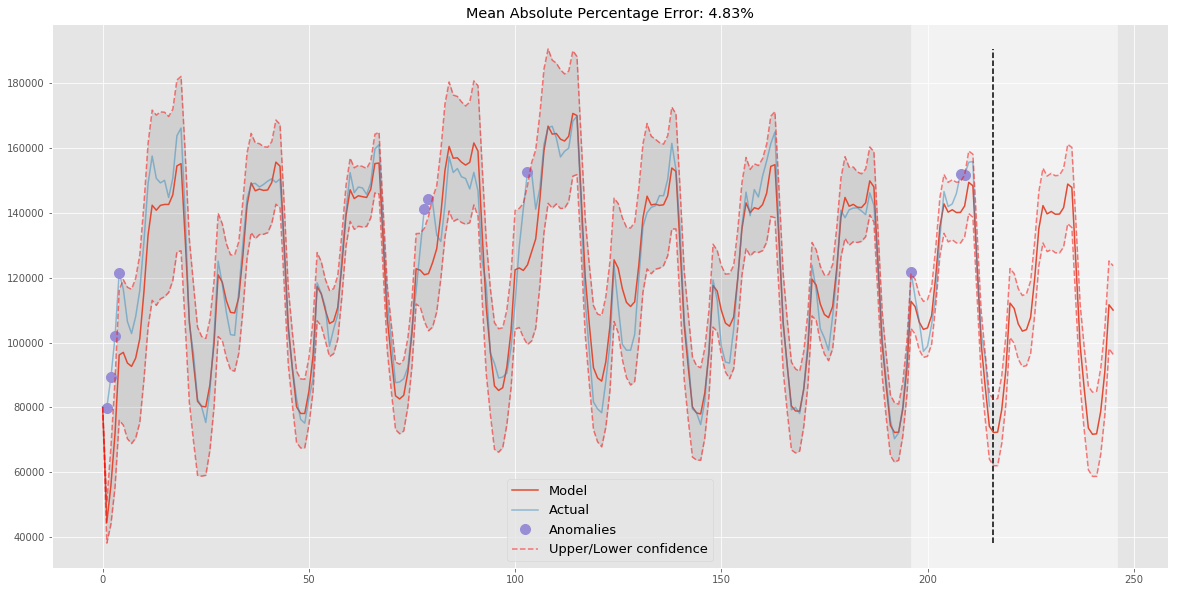

In [26]:
plotHoltWinters(df_ads.Ads, model)

In [27]:
data = df_cur.GEMS_GEMS_SPENT[:-50] 
s_len = 30
x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_absolute_percentage_error, s_len), method="TNC", bounds=((0, 1), (0, 1), (0, 1)))
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, s_len=s_len, alpha=alpha_final, beta=beta_final, gamma=gamma_final, n_pred=100, scale_factor=3)
model.triple_exponential_smooth()

0.012841445048055122 0.04883371471892228 0.00943678056045777


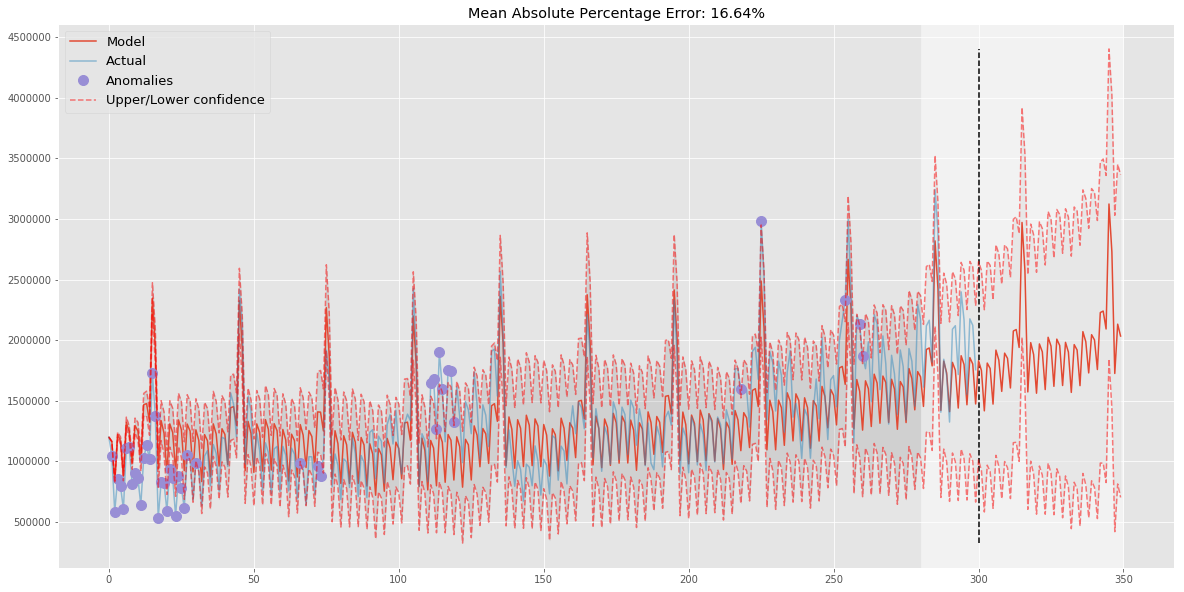

In [28]:
plotHoltWinters(df_cur.GEMS_GEMS_SPENT, model)

In [29]:
data = df_hour.ads[:-20]
x = [0, 0, 0]

opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_squared_error), method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)
model = HoltWinters(data, s_len=24, alpha=alpha_final, beta=beta_final, gamma=gamma_final, n_pred=150, scale_factor=3)
model.triple_exponential_smooth()

0.005689276101872254 0.005753931644250143 0.07937236124526587


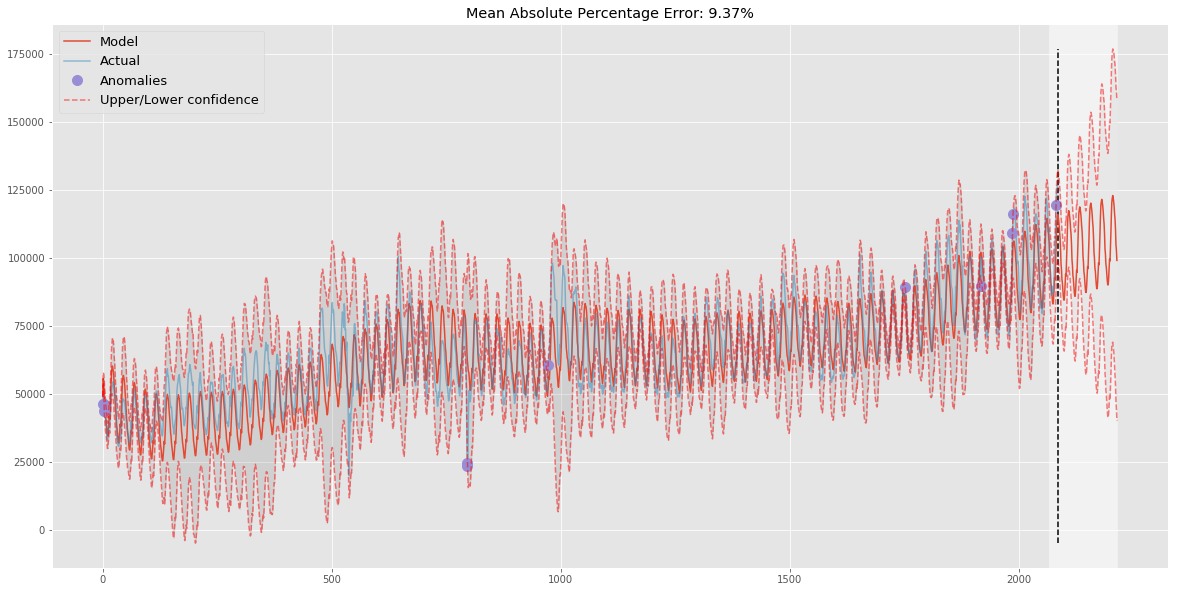

In [30]:
plotHoltWinters(df_hour.ads, model)

##  Time Series With Models

In [31]:
def timeseries_train_test_split(X, y, test_size):
    start_index = int(len(X) * (1-test_size))
    
    X_train = X.iloc[:start_index]
    X_test = X.iloc[start_index:]
    y_train = y.iloc[:start_index]
    y_test = y.iloc[start_index:]
    
    return X_train, X_test, y_train, y_test

In [32]:
lr = LinearRegression()

In [33]:
xgr = XGBRegressor(objective='reg:squarederror')

In [34]:
tscv = TimeSeriesSplit(n_splits=5)
scale = StandardScaler()

In [35]:
def plotModelResult(model, test_x, train_x, test_y, train_y):
    pred = model.predict(test_x)
    plt.figure(figsize=(12,7))
    plt.plot(pred, 'g', label='Prediction')
    plt.plot(test_y.values, label='Actual', alpha=0.5)
    
    cv = cross_val_score(model, train_x, train_y, cv=tscv, scoring='neg_mean_absolute_error')
    mae = cv.mean() * (-1)
    deviation = cv.std()
    scale = 1.9
    lower_bound = pred - (mae + scale * deviation)
    upper_bound = pred + (mae + scale * deviation)
    plt.plot(lower_bound, 'r--', alpha=0.5, label='Lower/Upper bound')
    plt.plot(upper_bound, 'r--', alpha=0.5)
    
    anomaly = np.array([np.NAN] * len(test_y))
    anomaly[test_y<lower_bound] = test_y[test_y<lower_bound]
    anomaly[test_y>upper_bound] = test_y[test_y>upper_bound]
    plt.plot(anomaly, 'o', label='Anomalies')
    
    plt.title('{0} Mean Aboslute Error Percentage {1:.2f}%'.format(type(model).__name__, mean_absolute_percentage_error(pred, test_y)))
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()

In [36]:
def plotCoefficient(model, train_x):
    df = pd.DataFrame(model.coef_, train_x.columns)
    df.columns = ['Coef']
    df['abs'] = df.Coef.apply(np.abs)
    df = df.sort_values(by='abs', ascending=False).drop('abs', axis=1)
    
    plt.figure(figsize=(12, 7))
    df.Coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.title('Cofficient bar-plot of {}'.format(type(model).__name__))
    plt.hlines(y=0, xmin=0, xmax=len(df), linestyles='dashed')

In [37]:
def models_with_time_series(series, model):
    data = pd.DataFrame(series.copy())
    data.columns = ['y']
    
    for i in range(6, 25):
        data['lag_' + str(i)] = data.y.shift(i)
    print(data.tail())
    
    X = data.dropna().drop('y', axis=1)
    y = data.dropna()['y']
    
    train_x, test_x, train_y, test_y = timeseries_train_test_split(X, y, test_size=0.3)
    x_train_scaled = scale.fit_transform(train_x)
    x_test_scaled = scale.transform(test_x)
    
    model.fit(x_train_scaled, train_y)
    plotModelResult(model, test_x=x_test_scaled, train_x=x_train_scaled, test_y=test_y, train_y=train_y)
    
    if type(model).__name__ == 'LinearRegression':
        plotCoefficient(model, test_x)

### df_ads

                          y     lag_6     lag_7     lag_8     lag_9    lag_10  \
Time                                                                            
2017-09-21 19:00:00  155890  141995.0  146630.0  132335.0  114380.0  105635.0   
2017-09-21 20:00:00  123395  142815.0  141995.0  146630.0  132335.0  114380.0   
2017-09-21 21:00:00  103080  146020.0  142815.0  141995.0  146630.0  132335.0   
2017-09-21 22:00:00   95155  152120.0  146020.0  142815.0  141995.0  146630.0   
2017-09-21 23:00:00   80285  151790.0  152120.0  146020.0  142815.0  141995.0   

                       lag_11    lag_12    lag_13    lag_14    lag_15  \
Time                                                                    
2017-09-21 19:00:00   98860.0   97290.0  106495.0  113950.0  121910.0   
2017-09-21 20:00:00  105635.0   98860.0   97290.0  106495.0  113950.0   
2017-09-21 21:00:00  114380.0  105635.0   98860.0   97290.0  106495.0   
2017-09-21 22:00:00  132335.0  114380.0  105635.0   98860.0   97290

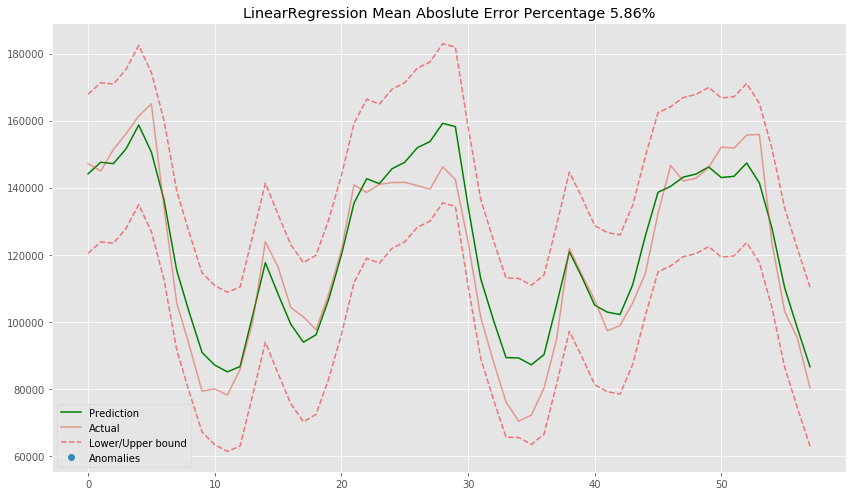

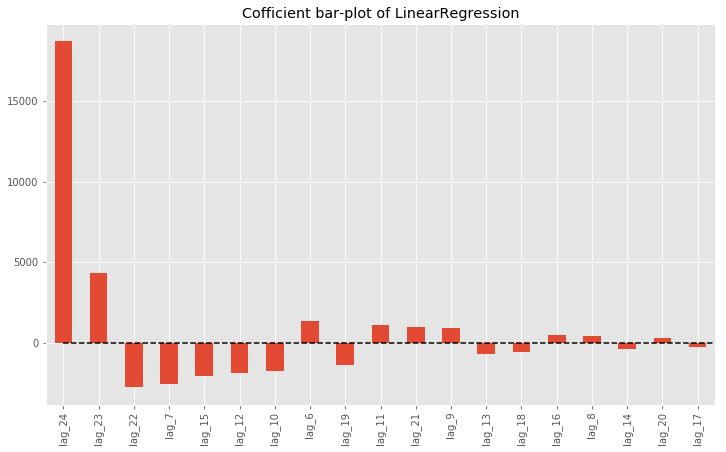

In [38]:
models_with_time_series(df_ads.Ads, lr)

                          y     lag_6     lag_7     lag_8     lag_9    lag_10  \
Time                                                                            
2017-09-21 19:00:00  155890  141995.0  146630.0  132335.0  114380.0  105635.0   
2017-09-21 20:00:00  123395  142815.0  141995.0  146630.0  132335.0  114380.0   
2017-09-21 21:00:00  103080  146020.0  142815.0  141995.0  146630.0  132335.0   
2017-09-21 22:00:00   95155  152120.0  146020.0  142815.0  141995.0  146630.0   
2017-09-21 23:00:00   80285  151790.0  152120.0  146020.0  142815.0  141995.0   

                       lag_11    lag_12    lag_13    lag_14    lag_15  \
Time                                                                    
2017-09-21 19:00:00   98860.0   97290.0  106495.0  113950.0  121910.0   
2017-09-21 20:00:00  105635.0   98860.0   97290.0  106495.0  113950.0   
2017-09-21 21:00:00  114380.0  105635.0   98860.0   97290.0  106495.0   
2017-09-21 22:00:00  132335.0  114380.0  105635.0   98860.0   97290

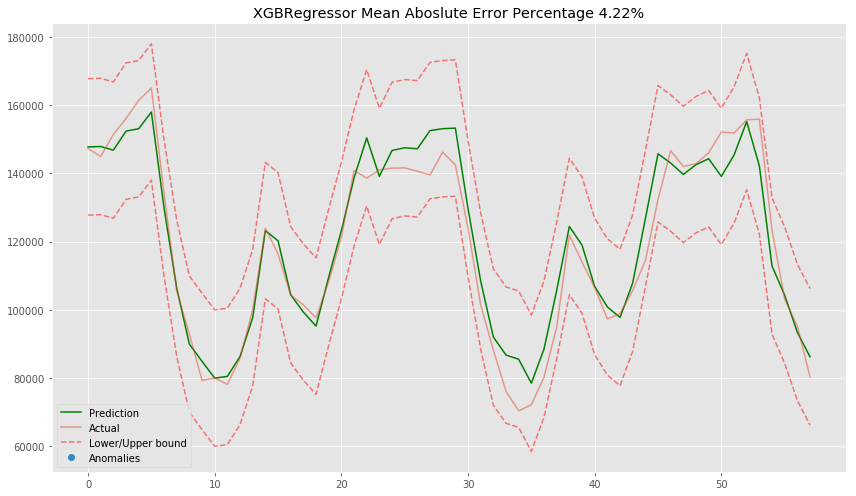

In [39]:
models_with_time_series(df_ads.Ads, xgr)

### df_hour

                          y     lag_6    lag_7    lag_8    lag_9   lag_10  \
Date                                                                        
2017-10-28 16:00:00  111837   89402.0  89520.0  86183.0  86338.0  87313.0   
2017-10-28 17:00:00  119322   86902.0  89402.0  89520.0  86183.0  86338.0   
2017-10-28 18:00:00  124567   88370.0  86902.0  89402.0  89520.0  86183.0   
2017-10-28 19:00:00  125366   95504.0  88370.0  86902.0  89402.0  89520.0   
2017-10-28 20:00:00  126644  102912.0  95504.0  88370.0  86902.0  89402.0   

                      lag_11   lag_12    lag_13    lag_14    lag_15    lag_16  \
Date                                                                            
2017-10-28 16:00:00  90123.0  96596.0  107069.0  110555.0  110909.0  109547.0   
2017-10-28 17:00:00  87313.0  90123.0   96596.0  107069.0  110555.0  110909.0   
2017-10-28 18:00:00  86338.0  87313.0   90123.0   96596.0  107069.0  110555.0   
2017-10-28 19:00:00  86183.0  86338.0   87313.0   90123

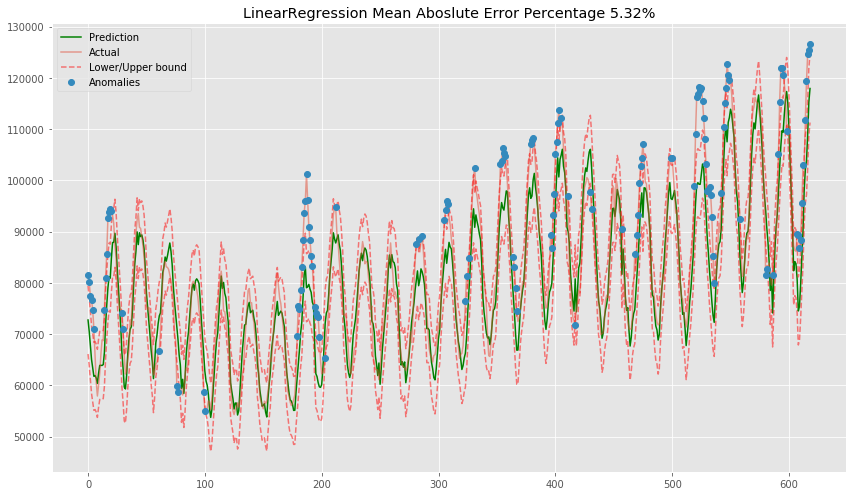

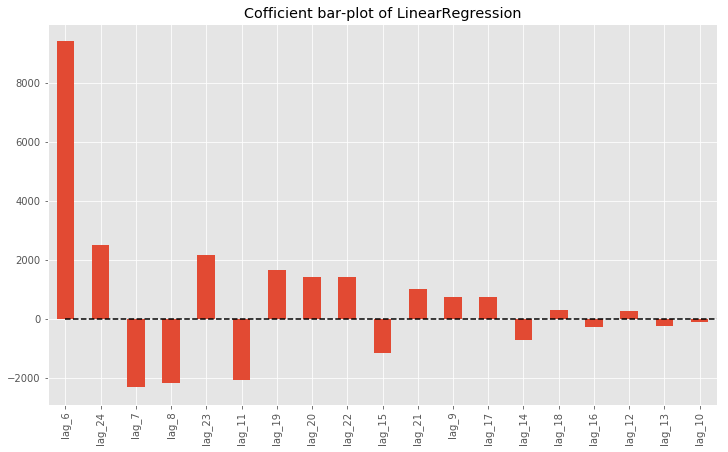

In [40]:
models_with_time_series(df_hour.ads, lr)

                          y     lag_6    lag_7    lag_8    lag_9   lag_10  \
Date                                                                        
2017-10-28 16:00:00  111837   89402.0  89520.0  86183.0  86338.0  87313.0   
2017-10-28 17:00:00  119322   86902.0  89402.0  89520.0  86183.0  86338.0   
2017-10-28 18:00:00  124567   88370.0  86902.0  89402.0  89520.0  86183.0   
2017-10-28 19:00:00  125366   95504.0  88370.0  86902.0  89402.0  89520.0   
2017-10-28 20:00:00  126644  102912.0  95504.0  88370.0  86902.0  89402.0   

                      lag_11   lag_12    lag_13    lag_14    lag_15    lag_16  \
Date                                                                            
2017-10-28 16:00:00  90123.0  96596.0  107069.0  110555.0  110909.0  109547.0   
2017-10-28 17:00:00  87313.0  90123.0   96596.0  107069.0  110555.0  110909.0   
2017-10-28 18:00:00  86338.0  87313.0   90123.0   96596.0  107069.0  110555.0   
2017-10-28 19:00:00  86183.0  86338.0   87313.0   90123

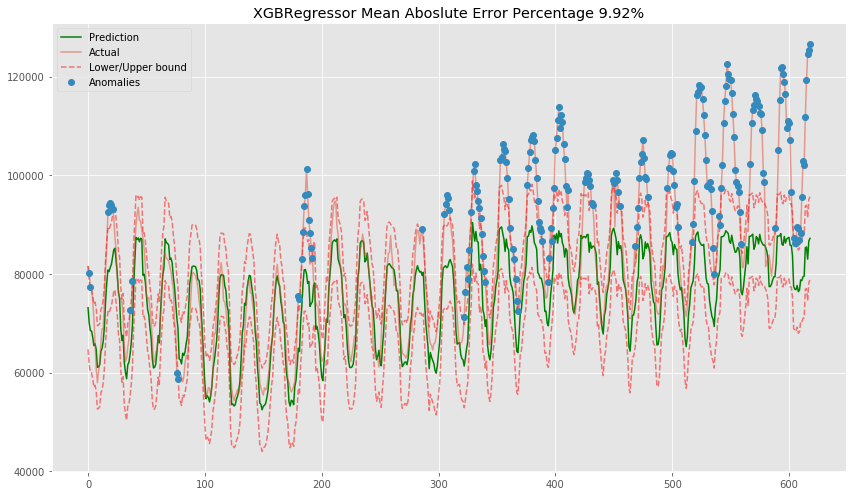

In [41]:
models_with_time_series(df_hour.ads, xgr)

### df_cur

                  y      lag_6      lag_7      lag_8      lag_9     lag_10  \
Time                                                                         
2018-02-20  2166449  1707899.0  1842610.0  1405753.0  2894633.0  3242154.0   
2018-02-21  1552313  1324588.0  1707899.0  1842610.0  1405753.0  2894633.0   
2018-02-22  2175548  2090271.0  1324588.0  1707899.0  1842610.0  1405753.0   
2018-02-23  2122606  2119260.0  2090271.0  1324588.0  1707899.0  1842610.0   
2018-02-24  1756394  1716590.0  2119260.0  2090271.0  1324588.0  1707899.0   

               lag_11     lag_12     lag_13     lag_14     lag_15     lag_16  \
Time                                                                           
2018-02-20  1819026.0  2164330.0  2117962.0  1612939.0  2172449.0  2294555.0   
2018-02-21  3242154.0  1819026.0  2164330.0  2117962.0  1612939.0  2172449.0   
2018-02-22  2894633.0  3242154.0  1819026.0  2164330.0  2117962.0  1612939.0   
2018-02-23  1405753.0  2894633.0  3242154.0  1819026.

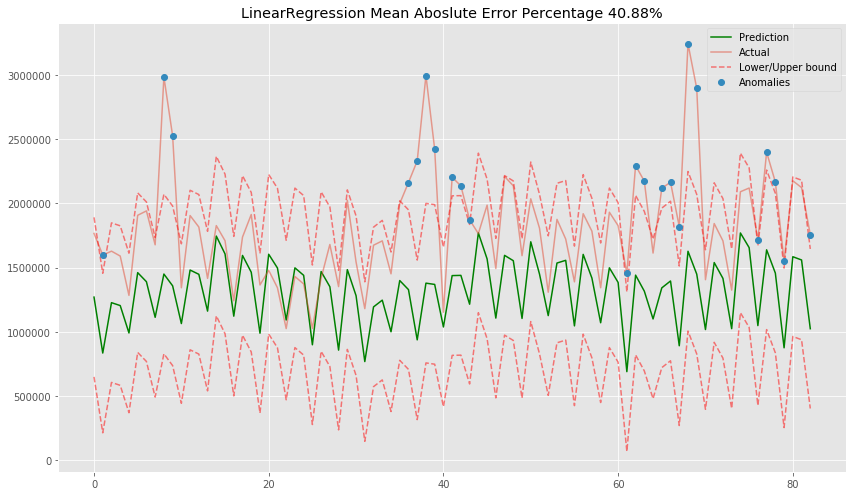

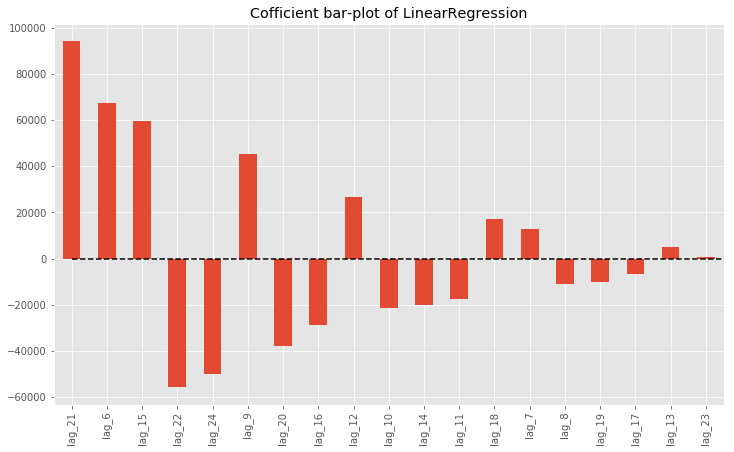

In [42]:
models_with_time_series(df_cur.GEMS_GEMS_SPENT, lr)

                  y      lag_6      lag_7      lag_8      lag_9     lag_10  \
Time                                                                         
2018-02-20  2166449  1707899.0  1842610.0  1405753.0  2894633.0  3242154.0   
2018-02-21  1552313  1324588.0  1707899.0  1842610.0  1405753.0  2894633.0   
2018-02-22  2175548  2090271.0  1324588.0  1707899.0  1842610.0  1405753.0   
2018-02-23  2122606  2119260.0  2090271.0  1324588.0  1707899.0  1842610.0   
2018-02-24  1756394  1716590.0  2119260.0  2090271.0  1324588.0  1707899.0   

               lag_11     lag_12     lag_13     lag_14     lag_15     lag_16  \
Time                                                                           
2018-02-20  1819026.0  2164330.0  2117962.0  1612939.0  2172449.0  2294555.0   
2018-02-21  3242154.0  1819026.0  2164330.0  2117962.0  1612939.0  2172449.0   
2018-02-22  2894633.0  3242154.0  1819026.0  2164330.0  2117962.0  1612939.0   
2018-02-23  1405753.0  2894633.0  3242154.0  1819026.

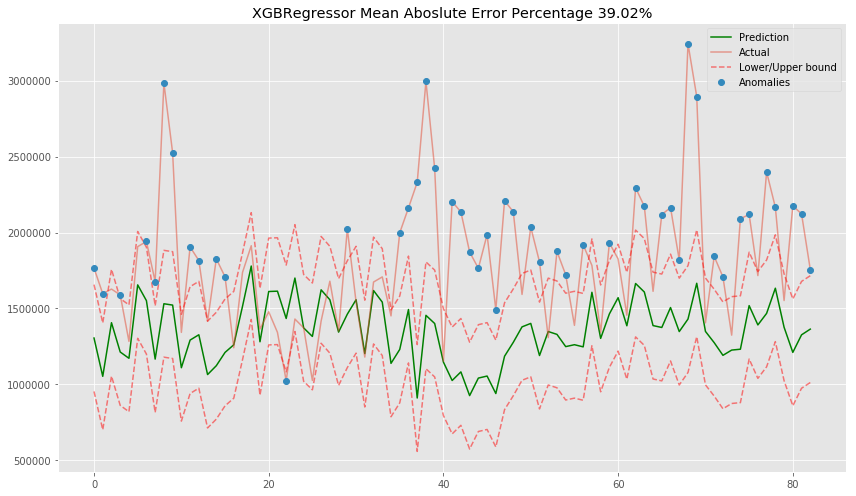

In [43]:
models_with_time_series(df_cur.GEMS_GEMS_SPENT, xgr)